In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

In [11]:
try:
    %tensorflow_version 2.x
    print ("Using TF2 in Google Colab")
except:
    pass
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.1.0'

## TF is a symbolic computic + optimization library for machine learning problems

ML expressions involve:

- variables representing data as n-dimensional objects
- variables representing parameters as n-dimensional objects
- mostly matrix operations (multiplications, convolutions, etc.)
- some non linear operations (activation functions)

for instance

**A perceptron**
$$\hat{y} = \text{sigmoid}(\mathbf{W}_2 \cdot \tanh(\mathbf{x^T} \cdot \mathbf{W}_1 + \mathbf{b}_1) + b_2)$$

with $\text{sigmoid}(z) = \frac{1}{1+e^{-z}}$

**Cost function (no regularization)**
$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2$$

**Cost (with regularization)**
$$J(\mathbf{b}_1, b_2, \mathbf{W}_1, \mathbf{W}_2) = \frac{1}{m}\sum_{i=0}^{m-1} (\hat{y}-y)^2 + \lambda \left[ || \mathbf{b}_1||^2 + b_2^2 + ||\mathbf{W}_1||^2 + ||\mathbf{W}_2||^2\right]$$


$\lambda$ regulates the participation of the regularization terms. Given a vector or matrix $\mathbf{T}$, its squared norm is denoted by $||\mathbf{T}||^2 \in \mathbb{R}$ and it's computed by squaring all its elements and summing them all up. 


## TF for symbolic computing

- `tf.Variable` represent a **symbolic** variable, that contains a value

In [3]:
x = tf.Variable(initial_value=[7], name="x", dtype=tf.float32)
y = tf.Variable(initial_value=[9], name="y", dtype=tf.float32)
f = x**2+y**3
f

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([778.], dtype=float32)>

for which TF can obtain gradients automatically

In [4]:
with tf.GradientTape(persistent=True) as t:
    f = x**2 + y**3
    
print (t.gradient(f, x), t.gradient(f, y))
    

tf.Tensor([14.], shape=(1,), dtype=float32) tf.Tensor([243.], shape=(1,), dtype=float32)


usually expressions are built within functions decorated with `@tf.function` for performance

In [5]:
@tf.function
def myf(x,y):
    return x**2 + y**3

In [6]:
with tf.GradientTape(persistent=True) as t:
    f = myf(x,y)
    
print (t.gradient(f, x), t.gradient(f, y))


tf.Tensor([14.], shape=(1,), dtype=float32) tf.Tensor([243.], shape=(1,), dtype=float32)


In [8]:
!rm -rf logs
mlutils.make_graph(myf, x, y, logdir="logs")


In [10]:
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 28826), started 1:15:08 ago. (Use '!kill 28826' to kill it.)

## Full example

we use the low level API to define our model class. observe how

- model output and loss function are built with symbolic expressions and decorated with `tf.function`
- we manually do gradient descent (`.fit` and `.train_step`)
- class inherits from `tf.keras.Model` and implements `__call__`, allowing it to call the model naturally for outputs

In [43]:
from progressbar import progressbar as pbar
from tensorflow.keras import Model
class NNModel(Model):
    def __init__(self, input_shape=2, neurons=5, reg=0.):
        super(NNModel, self).__init__()
        
        # define symbolic variables representing parameters
        self.W1 = tf.Variable(np.random.normal(size=(input_shape, neurons), scale=.6))
        self.b1 = tf.Variable(np.random.normal(size=neurons, scale=.6))
        
        self.W2 = tf.Variable(np.random.normal(size=(neurons, 1), scale=.6))
        self.b2 = tf.Variable(np.random.normal(size=1, scale=.6))
        
        self.params = [self.W1, self.b1, self.W2, self.b2]
        self.reg = reg
        self.neurons = neurons
        
    @tf.function
    def __call__(self, X):
        # define output function (yhat)
        layer1 = tf.tanh(tf.matmul(X,self.W1)+self.b1)
        return tf.sigmoid(tf.matmul(layer1,self.W2)+self.b2)

    @tf.function
    def train_step(self, X, y, lr):
        with tf.GradientTape() as t:
            y = tf.cast(tf.reshape(y,[-1]), tf.float64)
            ypred = tf.reshape(self(X), [-1])
            
            current_loss = 100*tf.reduce_mean(tf.square( y - ypred))
            current_loss += self.reg*tf.reduce_sum([tf.reduce_sum(i**2) for i in self.params])
    
        grads = t.gradient(current_loss, self.params)
        for p,g in zip(self.params, grads):
            p.assign_sub( lr * g)
        return current_loss

    def fit(self, X, y, epochs=4000, lr=0.5):        
        self.hloss = []
        for epoch in pbar(range(epochs)):
            current_loss = self.train_step(X, y, lr=lr)
            self.hloss.append(current_loss.numpy())
    
    def predict(self, X):
        return (self(X).numpy()>.5).astype(int)[:,0]
    
    def plot(self, X,y):
        plt.figure(figsize=(15,4))
        ax=plt.subplot(131)
        self.draw(ax=ax)
        plt.subplot(132)
        plt.plot(self.hloss)
        plt.xlabel("epochs"); plt.ylabel("loss"); plt.grid();
        plt.subplot(133)
        mlutils.plot_2Ddata_with_boundary(self.predict, X,y)
        plt.title("classification frontier, train accuracy %.2f"%np.mean(model.predict(X)==y));        

    def draw(self, ax=None):
        ax = plt.figure(figsize=(4,4)).add_subplot(111) if not ax else ax
        mlutils.draw_neural_net(ax, .1, .9, .1, .9, [2, self.neurons, 1])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.axis("off")        

a sample dataset

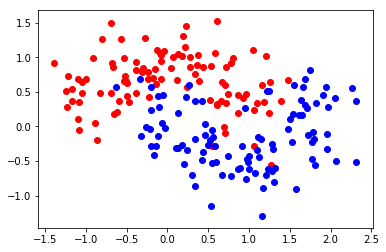

In [51]:
X, y = make_moons(200, noise=.3)

plt.scatter(X[:,0][y==0], X[:,1][y==0], color="red", label="class 0")
plt.scatter(X[:,0][y==1], X[:,1][y==1], color="blue", label="class 1")

### create at fit the network
with random initial weights

100% (5000 of 5000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


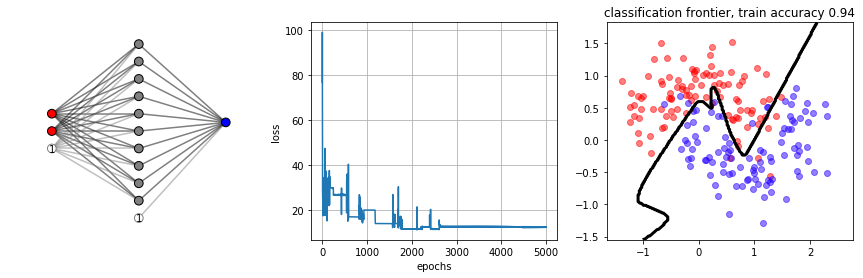

In [56]:
model = NNModel(neurons=10)
model.fit(X,y, epochs=5000, lr=.5)
model.plot(X,y)

obtain output and predictions

In [53]:
model(X)

<tf.Tensor: shape=(200, 1), dtype=float64, numpy=
array([[6.74743409e-04],
       [9.99999778e-01],
       [4.03359843e-05],
       [1.00000000e+00],
       [2.47476716e-03],
       [9.99994832e-01],
       [9.99992767e-01],
       [9.99981605e-01],
       [1.13734828e-08],
       [1.00000000e+00],
       [9.39175264e-01],
       [9.99999993e-01],
       [9.99999974e-01],
       [6.17619700e-05],
       [1.00000000e+00],
       [1.00000000e+00],
       [9.99983262e-01],
       [2.71649784e-03],
       [9.98777762e-01],
       [9.99999721e-01],
       [9.48276910e-01],
       [1.00000000e+00],
       [6.42280065e-05],
       [1.00000000e+00],
       [9.99986303e-01],
       [9.99999771e-01],
       [7.54400138e-01],
       [1.00000000e+00],
       [3.53579220e-01],
       [6.56667216e-07],
       [1.00000000e+00],
       [9.17294594e-07],
       [8.92226527e-08],
       [6.67587824e-04],
       [8.92813703e-01],
       [9.99999778e-01],
       [6.50069479e-01],
       [9.99985282e-01],


In [55]:
model.predict(X)

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0])

of course regularization works as expected

100% (5000 of 5000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


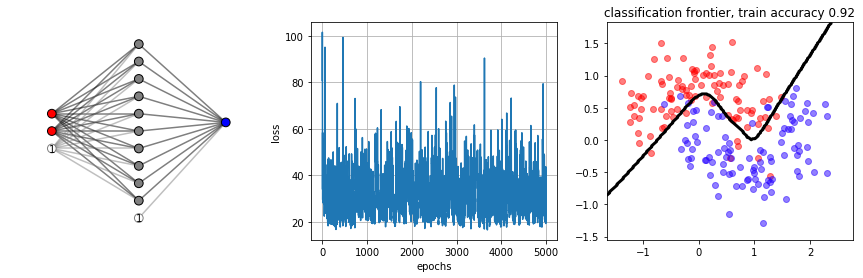

In [58]:
model = NNModel(neurons=10, reg=.01)
model.fit(X,y, epochs=5000, lr=.5)
model.plot(X,y)